**NOTE:** This is a notebook supporting a blog post. More than likely I will not just convert the notebook into markdown and publish. Instead, I'll likely be selective with what code I show in the blogpost _and_ I'll likely upload manually annotated graphviz plots for the final post.

# TODO
* Link to this post https://deploy-preview-222--pymc-labs-website-source.netlify.app/blog-posts/out-of-model-predictions-with-pymc/

# New Bayesian and Causal inference workflows in PyMC: Introducing the new `observe` and `do` functions

We've got some exciting experimental new functionality coming to PyMC which helps users do graph manipulation. If you don't know what that is, then you will soon! But know that this will be particularly useful in both Bayesian and Causal inference workflows.

This post is going to cover a lot of ground, so strap in. Readers of this post are going to learn:
* That PyMC models are represented behind the scenes as Bayesian DAGS
* That we can manipulate these graphs in a variety of ways for fun and profit
* How new `do` and `observe` functions allow a more intuitive Bayesian workflow
  1. Defining the full data generating process in the absence of any data
  2. Perform graph manipulation by injecting _parameter values_ with the new `do` function. This is useful as you can sample from this new model to generate simulated datasets.
  3. Again perform graph manipulation by injecting _data_ (using `observe`) to obtain a new model which we can use to infer posterior distributions over latent parameters given the data.
  4. We can also use the `do` operator, but this time to calculate counterfactuals and conduct posterior prediction for out of sample predictions (for example). Before these updates, users were already performing graph manipulation through the use of `pm.sample_posterior_predictive`, but now we can use the new `do` operator.
* That PyMC models can be considered as implementing Bayesian versions of Pearl's Structural Causal Models.
  * We can use the do operator in _causal_ inference workflows.


**NOTE:** The functionality we talk about in this post, specifically the `do` and `observe` functions rely on some experimental code. Therefore these functions exist in the suitably named [`pymc-experimental`](https://github.com/pymc-devs/pymc-experimental) repo.

Setup an environment as follows:

```bash
mamba create -n do_observe python=3.11 pymc-base matplotlib numpy pandas seaborn scipy jupyterlab ipykernel python-graphviz
mamba activate do_observe
python -m ipykernel install --user --name do_observe
pip install pymc-experimental
pip install daft
```

In [1]:
import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_experimental as pmx
import seaborn as sns
from packaging import version

In [2]:
# check we have the required versions
assert version.parse(pm.__version__) >= version.parse('5.4.1')
assert version.parse(pmx.__version__) >= version.parse('0.0.5')

In [3]:
# import the new functionality
from pymc_experimental.model_transform.conditioning import do, observe

In [4]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [10, 6]
SEED = 1234
rng = np.random.default_rng(SEED)

Conducting Bayesian inference using MCMC methods in the current era has two key requirements: a) a log probability density for any given set of latent parameters and data, and b) gradient information about that log probability density.

However, an optional component of probabilistic programming libraries (PPL's) would be to have a representation of the graph structure of any given model. PyMC is one of those libraries! While having a graph representation of computations is common in various deep learning and related frameworks (e.g. [TensorFlow](https://www.tensorflow.org/guide/intro_to_graphs), [PyTorch](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/), [JAX](https://bnikolic.co.uk/blog/python/jax/2022/02/22/jax-outputgraph-rev.html), [Oryx](https://github.com/jax-ml/oryx), [aesara](https://aesara.readthedocs.io/en/latest/)/[aeMCMC](https://aemcmc.readthedocs.io/en/latest/index.html)/[aePPL](https://github.com/aesara-devs/aeppl)), it is not ubiquitous. For example, neither [JAGS](https://en.wikipedia.org/wiki/Just_another_Gibbs_sampler) nor [STAN](https://mc-stan.org) have an internal graph-based representation - they are centered around the log probability and its gradient. 

One advantage that PyMC has however is that the graph representation is a first-class citizen. So when you build your PyMC model, it constructs a symbolic graph representation of the model which is then relatively easy to manipulate in various ways. One promising use case for this is automagical graph transformations - here PyMC could analyse a model and simplify it, by looking for conjugate priors for example. Another use case is explicit user-driven modification of the graph which we'll focus on in this post.

To understand what we mean in more detail, let's consider some routine functionality that has been in PyMC for some time now, that of out of sample posterior prediction.

## New Bayesian workflows

The schematic figure below shows how we can can use PyMC to solve our Bayesian infence problems.

The existing approach to date, is to specify an "inference model" in PyMC which basially represents the posterior distribution of the latent variables, condititioned on the data, $P(\Theta|D=d)$. This is the red shaded area in the diagram. This

# TODO: PERFECT A FIGURE TO DEMONSTRATE THE WORKFLOW

## Example 1 - New Bayesian workflow

## TODO: Re-write this cell
Let's take a univariate regression problem as an example. A typical (but not complete) Bayesian workflow would consist of the following stages:
* Build a linear regression model in PyMC with our observed data stored as `MutableData` nodes.
* Run inference on the unknown coefficients with `pm.sample`
* Run out-of-sample prediction by updating the observed predictor values (`MutableData` nodes) with new values.

This last step is an example of graph manipulation where a user dives in and changes the values of a `MutableData` node with new values. This was already achievable with `pm.set_data`, and there are plenty of example notebooks demonstrating this on the [PyMC Examples gallery](https://www.pymc.io/projects/examples/en/latest/gallery.html) section of the website.

But let's see this workflow in action with the new `do` operator functionality

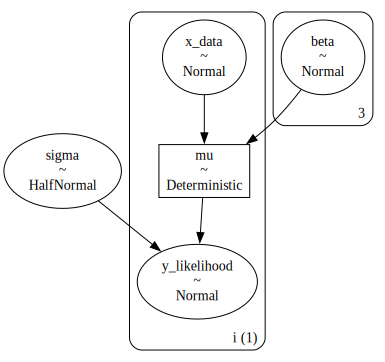

In [5]:
coords = {'i': [0]}

with pm.Model(coords_mutable=coords) as model_generative:
    x_data = pm.Normal("x_data", dims="i")
    beta = pm.Normal('beta', shape=3)
    sigma = pm.HalfNormal('sigma')
    mu = pm.Deterministic("mu", beta[0] + beta[1] * x_data + beta[2] * x_data**2, dims="i")
    pm.Normal('y_likelihood', mu=mu, sigma=sigma, dims="i")
    
pm.model_to_graphviz(model_generative)

# TODO: Add text introducing the do operator. Here or in the intro

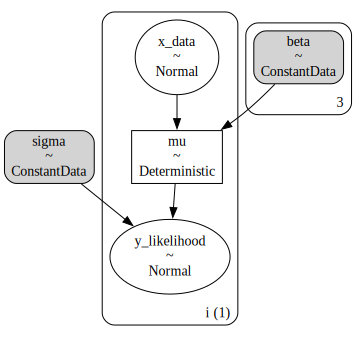

In [6]:
true_values = {"beta": np.array([-2, 0.5, -0.8]), "sigma": 0.2}
model_simulate = do(model_generative, true_values)

pm.model_to_graphviz(model_simulate)

Sampling: [x_data, y_likelihood]


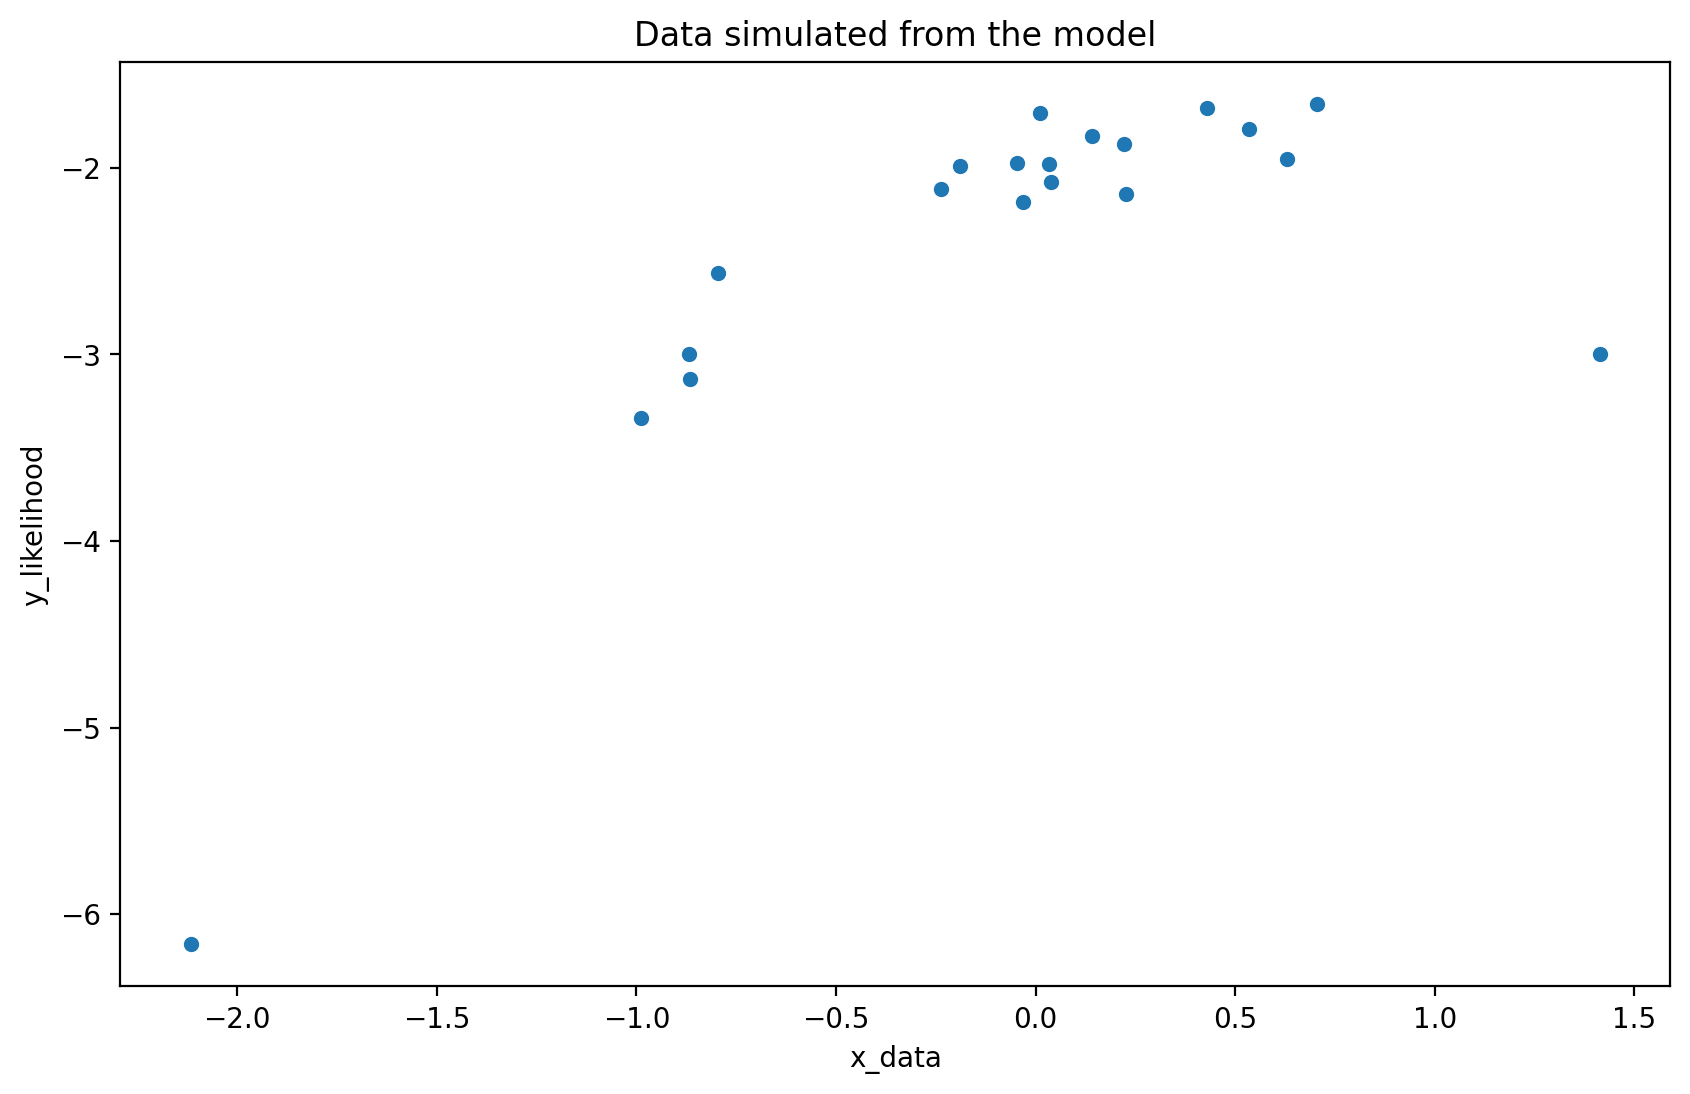

In [7]:
N = 20

# METHOD 1
with model_simulate:
    model_simulate.set_dim("i", N, coord_values=np.arange(N))
    simulate = pm.sample_prior_predictive(samples=1)
    
# METHOD 2
# with model_simulate:
#     simulate = pm.sample_prior_predictive(samples=N)

observed = {"x_data": simulate.prior['x_data'].values.flatten(), 
            "y_likelihood": simulate.prior['y_likelihood'].values.flatten()}

df = pd.DataFrame(observed)
ax = sns.scatterplot(df, x="x_data", y="y_likelihood")
ax.set(title="Data simulated from the model");

### Inference, $P( \theta | x, y)$

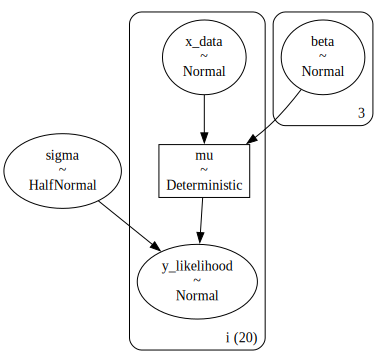

In [8]:
pm.model_to_graphviz(model_generative)

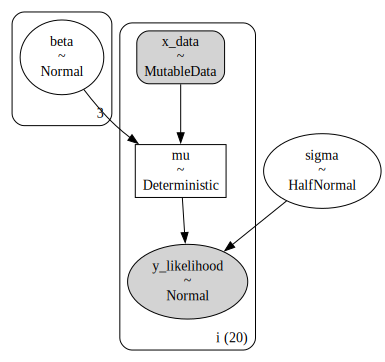

In [9]:
# model_inference = observe(model_generative, {"x_data": observed['x_data'], "y_likelihood": observed['y_likelihood']})

import pytensor

model_inference = do(model_generative, {"x_data": pytensor.shared(observed['x_data'])})
model_inference = observe(model_inference, {"y_likelihood": observed['y_likelihood']})

model_inference.set_dim("i", N, coord_values=np.arange(N))
    
pm.model_to_graphviz(model_inference)

In [10]:
with model_inference:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


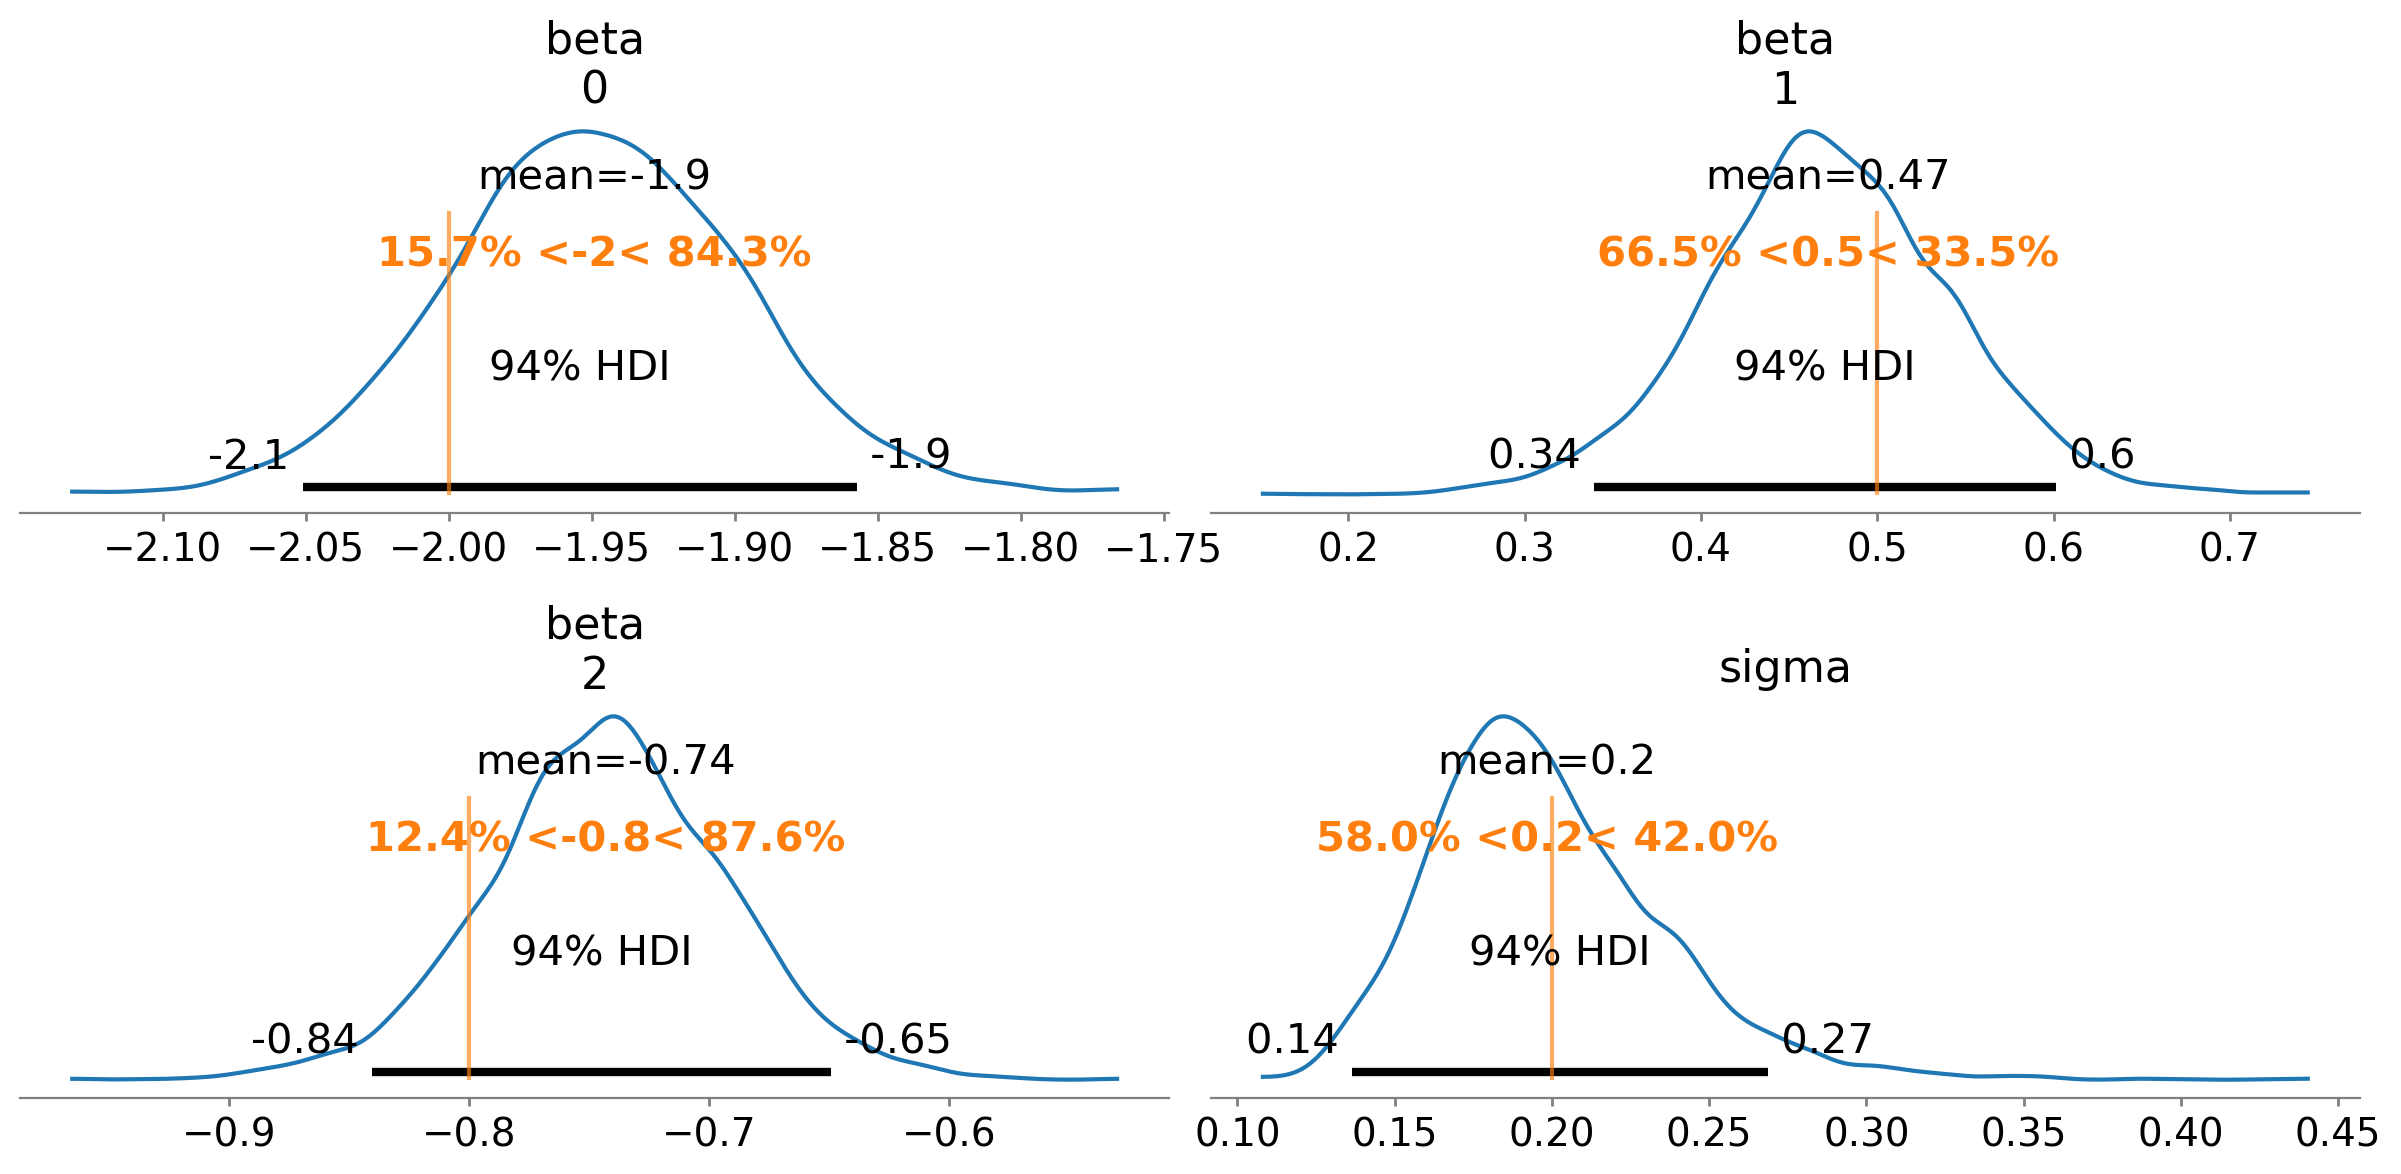

In [11]:
az.plot_posterior(idata, 
                  var_names=['beta', 'sigma'], 
                  ref_val=list(true_values['beta']) + [true_values['sigma']], 
                  grid=(2,2), 
                  figsize=(12, 6))
plt.tight_layout()

In [12]:
# # 3. Out of sample posterior prediction - the old way
# NI = 100
# xi = np.linspace(np.min(observed['x_data']), np.max(observed['x_data']), NI)

# with model_inference:
#     pm.set_data({'x_data': xi}, coords={"obs_id": np.arange(NI)})
#     idata.extend(pm.sample_posterior_predictive(idata, var_names=["mu"], predictions=True))
    
# pm.model_to_graphviz(model_pred)

What we've done here ~~is to manipulate the graph by injecting new data into the $x$ and $y$ `MutableData` nodes~~. If we visualise the model, we can see this as the label in the plate now shows that we have 100 instances of these variables in the graph.

### Graph manipulation for out of sample prediction - the new way

~~So let's introduce the `do` operator.~~ This function allows you to do graph manipulation in the same way that we achieved with `pm.set_data`. Though if you read on further you'll see that this is just the tip of the iceberg.

In [13]:
# the new way

NI = 100
xi = np.linspace(np.min(observed['x_data']), np.max(observed['x_data']), NI)

# model_pred = do(model_inference, {'x_data': xi, 'y_likelihood': np.full(NI, np.nan)})
model_pred = do(model_inference, {'x_data': xi})
model_pred.set_dim("i", NI, coord_values=np.arange(NI))

with model_pred:
    idata_pred = pm.sample_posterior_predictive(idata, var_names=["mu"], predictions=True)

Sampling: []


Checking the updated graph shows the same graph manipulation has taken place.

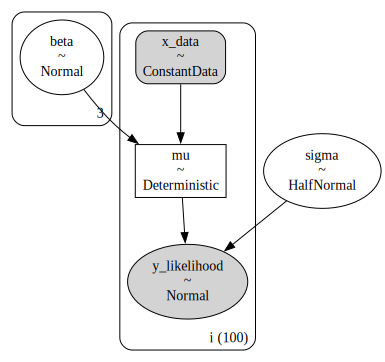

In [14]:
pm.model_to_graphviz(model_pred)

Just to convince you that these do the same operations, here's a plot of the out of sample predictions using both methods

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


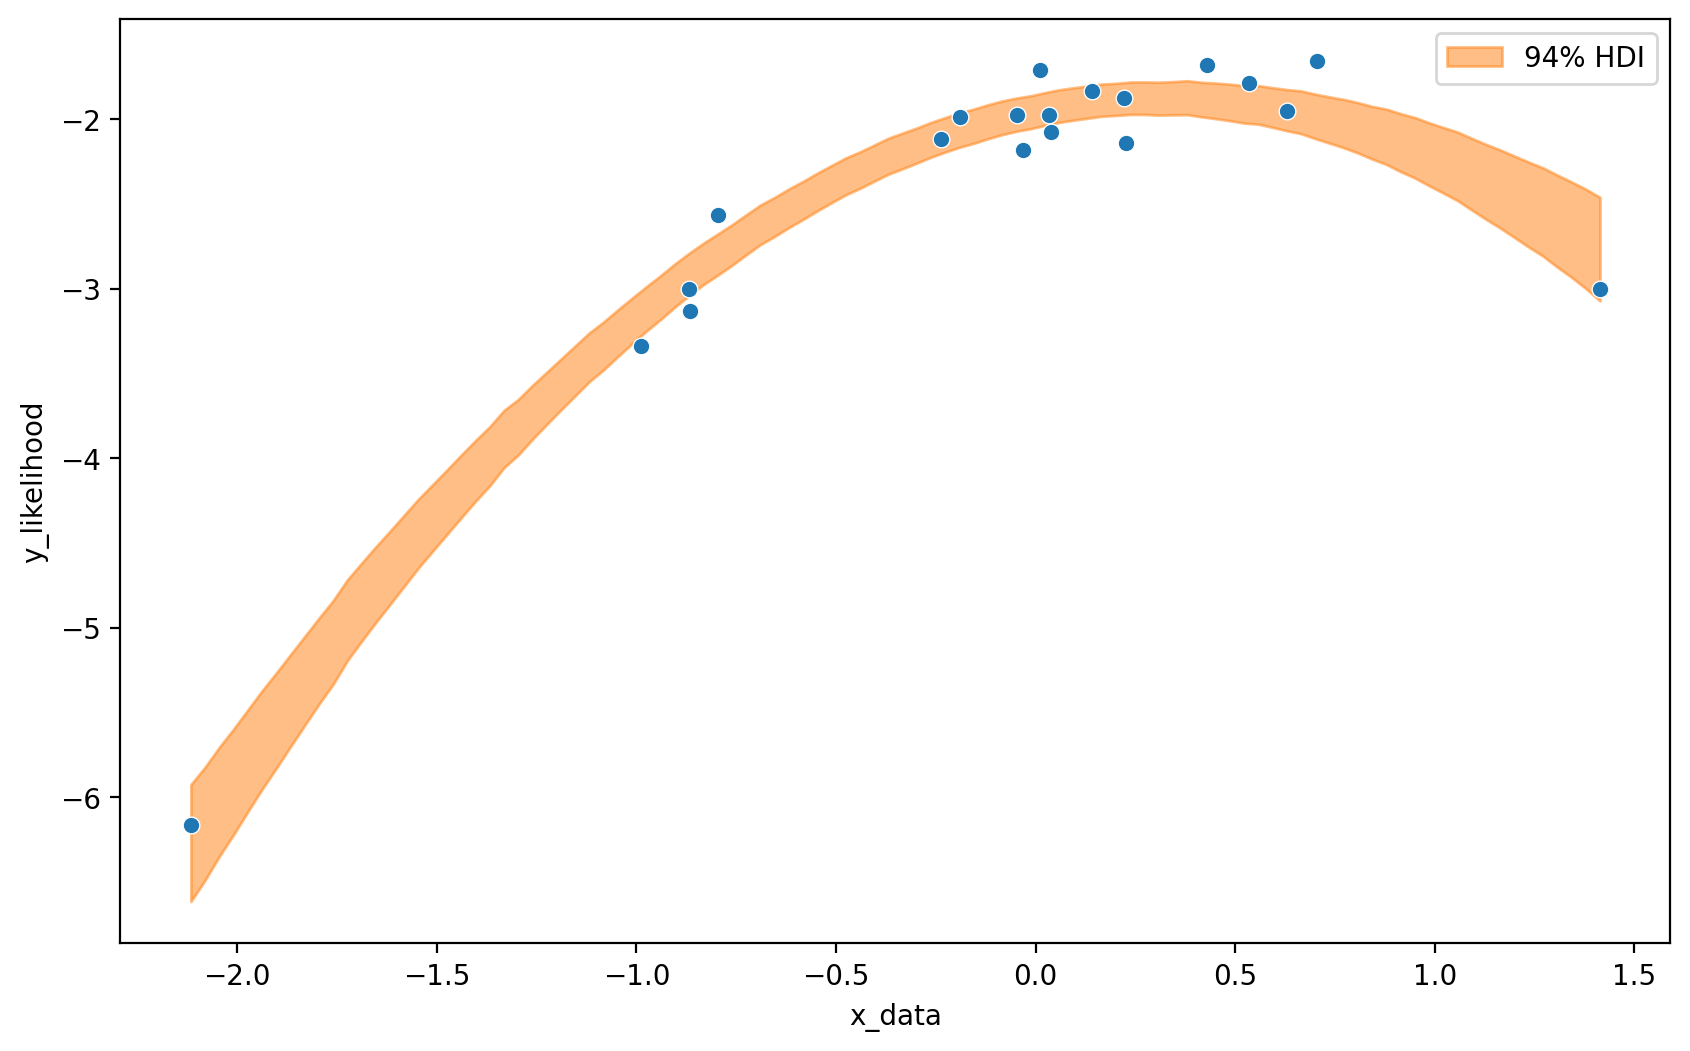

In [15]:
az.plot_hdi(xi, idata_pred.predictions['mu'], smooth=False, fill_kwargs={"label": "94% HDI"})
sns.scatterplot(df, x='x_data', y='y_likelihood')
ax.set(title="Out of sample prediction using pm.do")
ax.legend();

So you can see that we have predicted the outcome for a whole range of $x$ values that were not contained in the original dataset.

This example has introduced the concept of graph manipulation in an already commonly used situation, out of sample posterior prediction.

So far we've only seen that we can use the `do` operator to inject new data into `MutableData` nodes. But let's take this to 11 and see what we can do ;)

---

# TODO: If the code above works out, then replace the Example 1 stuff below

In [ ]:
# 1. Simulate data
N = 20
x = np.random.normal(0, 1, N)
y = -2 + 0.5 * x + -0.8 * x**2 + np.random.normal(0, 0.2, N)
df = pd.DataFrame({"x": x, "y": y})

# 2. Build a PyMC model
with pm.Model(coords_mutable={"obs_id": np.arange(N)}) as model:
    x_data = pm.MutableData('x_data', df['x'], dims="obs_id")
    y_data = pm.MutableData('y_data', df['y'], dims="obs_id")
    beta = pm.Normal('beta', shape=3)
    sigma = pm.HalfNormal('sigma')
    mu = pm.Deterministic("mu", beta[0] + beta[1] * x_data + beta[2] * x_data**2, dims="obs_id")
    pm.Normal('y_likelihood', mu=mu, sigma=sigma, observed=y_data, dims="obs_id")
    
pm.model_to_graphviz(model)

### Inference, $P( \theta | x, y)$

In [ ]:
# model_inference = observe(model, {"x_data": x, "y_data": y})
# model_inference.set_dim("i", N, coord_values=np.arange(N))
    
# pm.model_to_graphviz(model_inference)

In [ ]:
with model:
    idata = pm.sample()

### Graph manipulation for out of sample prediction - the old way

In [ ]:
# 3. Out of sample posterior prediction - the old way
NI = 100
xi = np.linspace(-3, 3, NI)
yi = np.full(NI, np.nan)
     
with model:
    pm.set_data({'x_data': xi, 'y_data': yi}, coords={"obs_id": np.arange(NI)})
    idata.extend(pm.sample_posterior_predictive(idata, var_names=["mu"]))

What we've done here is to manipulate the graph by injecting new data into the $x$ and $y$ `MutableData` nodes. If we visualise the model, we can see this as the label in the plate now shows that we have 100 instances of these variables in the graph.

In [ ]:
pm.model_to_graphviz(model)

### Graph manipulation for out of sample prediction - the new way

So let's introduce the `do` operator. This function allows you to do graph manipulation in the same way that we achieved with `pm.set_data`. Though if you read on further you'll see that this is just the tip of the iceberg.

In [ ]:
with do(model, {'x_data': xi, 'y_data': yi}) as model_pred:
    idata_pred = pm.sample_posterior_predictive(idata, var_names=["mu"])

Checking the updated graph shows the same graph manipulation has taken place.

In [ ]:
pm.model_to_graphviz(model_pred)

Just to convince you that these do the same operations, here's a plot of the out of sample predictions using both methods

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

az.plot_hdi(xi, idata.posterior_predictive['mu'], smooth=False, ax=ax[0], fill_kwargs={"label": "94% HDI"})
sns.scatterplot(df, x=x, y=y, ax=ax[0])
ax[0].set(title="Out of sample prediction using pm.set_data", xlabel=r"$x$", ylabel=r"$y$")
ax[0].legend()

az.plot_hdi(xi, idata_pred.posterior_predictive['mu'], smooth=False, ax=ax[1], fill_kwargs={"label": "94% HDI"})
sns.scatterplot(df, x=x, y=y, ax=ax[1])
ax[1].set(title="Out of sample prediction using pm.do")
ax[1].legend();

So you can see that we have predicted the outcome for a whole range of $x$ values that were not contained in the original dataset.

This example has introduced the concept of graph manipulation in an already commonly used situation, out of sample posterior prediction.

So far we've only seen that we can use the `do` operator to inject new data into `MutableData` nodes. But let's take this to 11 and see what we can do ;)

---

## Example 2 - Taking your Bayesian causal inference workflow to the next level - graph manipulation with `observe` and `do`.

**Potentially refine this suggested text from Thomas. Either way, we need some intro to causal inference. E.g. reference relevant `pymc-examples`:** You might have read that you can't do causal analysis in a Bayesian framework, and if you take a restricted or very formal definition of Bayesian statistics, maybe such an argument can be constructed. But as we're showing here, there really is nothing from stopping us from using the causal methods and adding them into our Bayesian toolbox. At the end of the day, these are all just tools and in this instance we can combine them to get the best of both worlds.

### The example we'll work with

In this post, we'll be working with an idiomatic causal DAG where we have a binary treatment variable $Z$ which may or may not causally influence an outcome $Y$. However, this relationship suffers from confounding by $C$ which causally influences both treatment and outcome.

Further, we turn this into a Bayesian causal DAG by specifying probabilistic causal relationships between the nodes. A prior is placed on $C$ as it has no parent nodes.

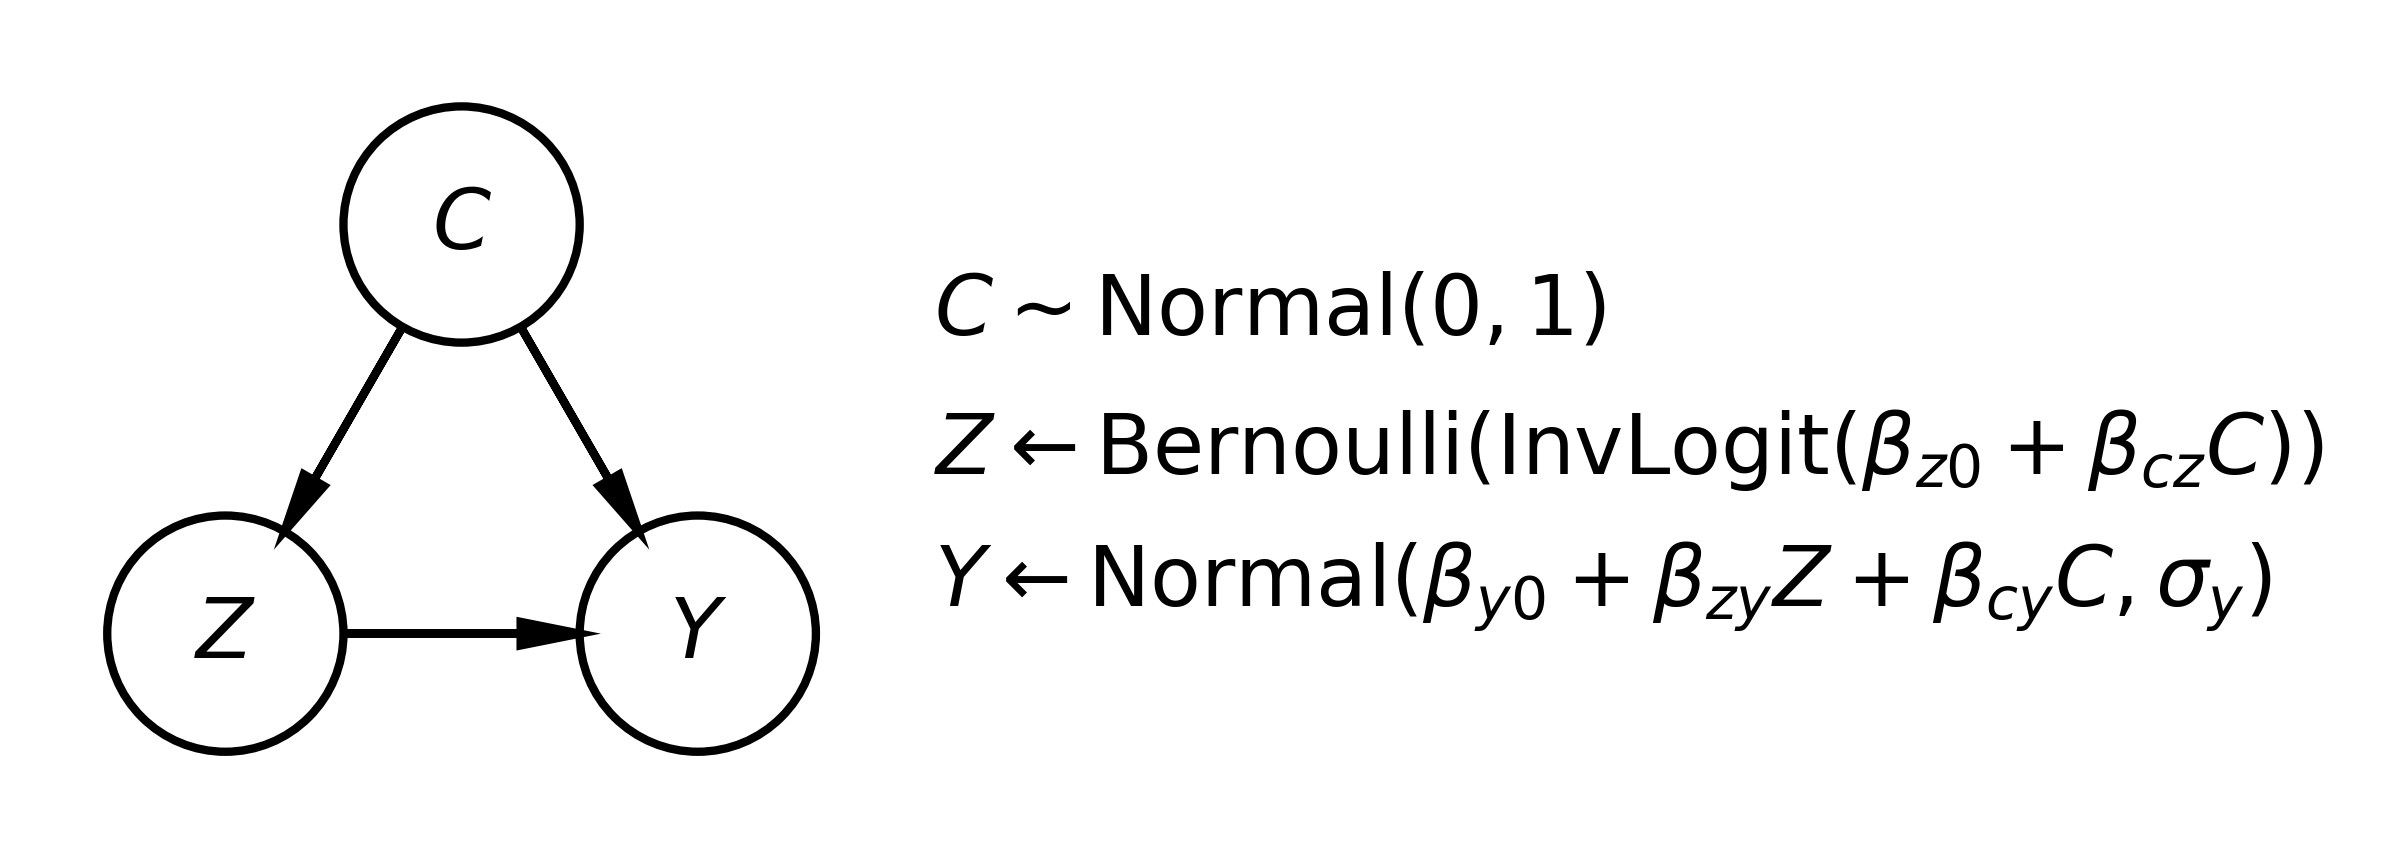

In [16]:
pgm = daft.PGM()
pgm.add_node("y", "$Y$", 0, 0)
pgm.add_node("z", "$Z$", -1, 0)
pgm.add_node("c", "$C$", -0.5, 0.866)
pgm.add_edge("z", "y")
pgm.add_edge("c", "y")
pgm.add_edge("c", "z")
pgm.add_text(0.5, 0.6, r"$C \sim \mathrm{Normal}(0, 1)$")
pgm.add_text(0.5, 0.3, r"$Z \leftarrow \mathrm{Bernoulli}(\operatorname{InvLogit}(\beta_{z0} + \beta_{cz} C))$")
pgm.add_text(0.5, 0, r"$Y \leftarrow \mathrm{Normal}(\beta_{y0} + \beta_{zy} Z + \beta_{cy} C, \sigma_y)$")
pgm.render(dpi=300);

# TODO: explain this is confounding (not mediation) but it depends

# TODO: Explain our causal and inferential goals with this example

To make life a bit simpler, let's define some terminology:
* We have random variables $C$, $Z$, and $Y$
* These are different from observations, specific values, $c$, $z$, and $y$
* We have a set of latent parameters, $\theta = \{ \beta_{z0}, \beta_{y0}, \beta_{zy}, \beta_{zy}, \beta_{cz}, \sigma_{y} \}$

### Define the full data generating process in a PyMC model

At the moment we have to pre-define the number of observations we are dealing with, here it will be `N=100`.

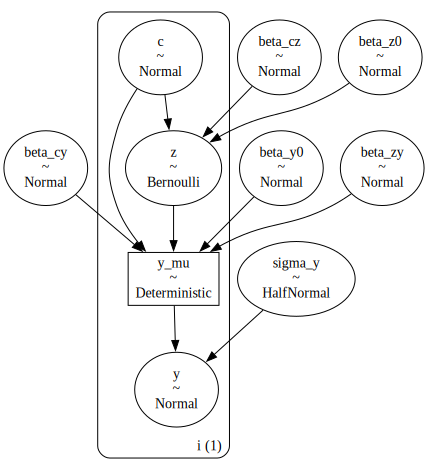

In [17]:
with pm.Model(coords_mutable={'i': [0]}) as model_generative:
    # priors on y <- c -> z
    beta_y0 = pm.Normal("beta_y0")
    beta_cy = pm.Normal("beta_cy")
    beta_cz = pm.Normal("beta_cz")
    # priors on z -> y causal path
    beta_z0 = pm.Normal("beta_z0")
    beta_zy = pm.Normal("beta_zy")
    # observation noise on y
    sigma_y = pm.HalfNormal("sigma_y")
    # core nodes and causal relationships
    c = pm.Normal("c", mu=0, sigma=1, dims='i')
    z = pm.Bernoulli("z", p=pm.invlogit(beta_z0 + beta_cz * c), dims='i')
    y_mu = pm.Deterministic("y_mu", beta_y0 + (beta_zy * z) + (beta_cy * c), dims='i')
    y = pm.Normal("y", mu=y_mu, sigma=sigma_y, dims='i')
        
    
pm.model_to_graphviz(model_generative)

### Simulate data by condition upon true parameter values and sampling

Having defined the full joint distribution, we are going to use it to generate simulated data. In order to do that, we are going to specify some true parameter values that govern the causal relationships between nodes.  So let's do that and use the `observe` function to generate a new model - when we plot that we can see that the parameters are now observed nodes.

# ERROR? Nodes are showing as shaded, but still as RV's, not data nodes

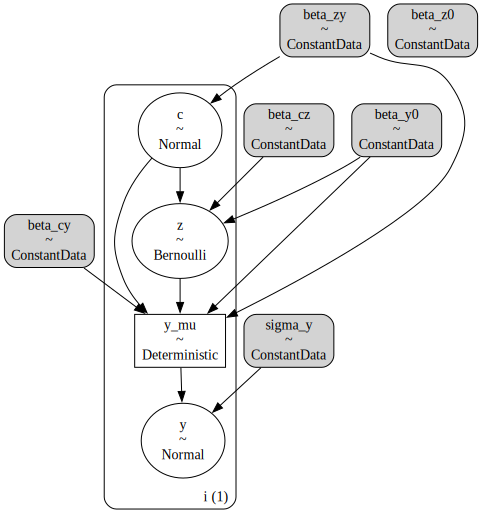

In [18]:
true_ATE = 1.0

true_values = {"beta_z0": 0.0, 
               "beta_y0": 0.0, 
               "beta_cz": 1.5, 
               "beta_zy": true_ATE, 
               "beta_cy": 1.0, 
               "sigma_y": 0.2}

model_simulate = do(model_generative, true_values)

pm.model_to_graphviz(model_simulate)

<div class="alert alert-block alert-info">
<b>Note:</b> It's important to pay attention to what we've just done. We took a model of the data generating process where there was no observed data, no conditioning. But we've returned a new and different model where we have now conditioned upon certain parameter values.</div>

Next, we'll sample from this new model to obtain samples from distibution $P(C, Z, Y | \theta)$.

Sampling: [c, y, z]


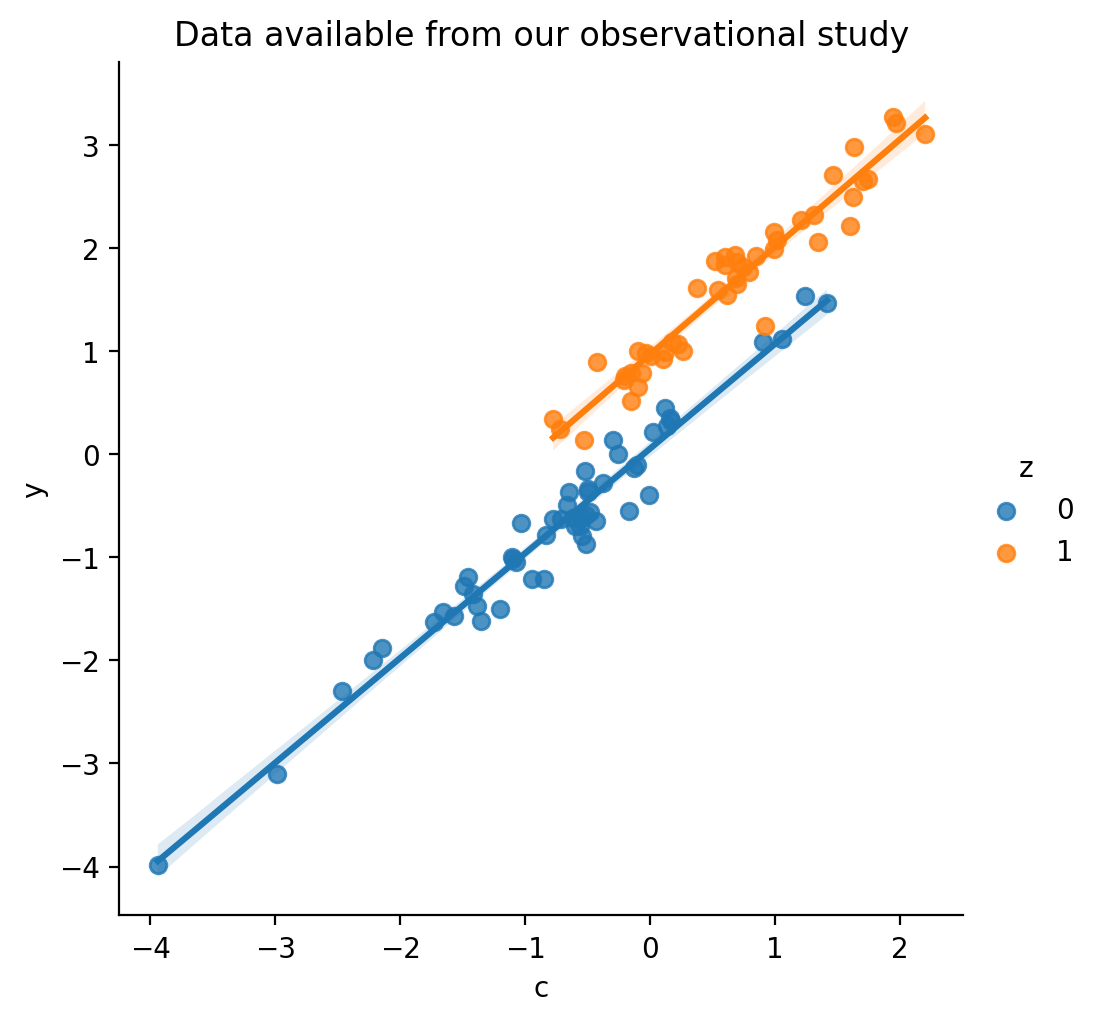

In [19]:
N = 100

with model_simulate:
    simulate = pm.sample_prior_predictive(samples=N)
    
observed = {"c": simulate.prior['c'].values.flatten(), 
            "y": simulate.prior['y'].values.flatten(),
            "z": simulate.prior['z'].values.flatten()}

df = pd.DataFrame(observed)
ax = sns.lmplot(df[["c", "z", "y"]], x="c", y="y", hue="z")
ax.set(title="Data available from our observational study");

_Note that these fits + shaded error regions are not Bayesian fits. These are carried out automatically by `seaborn`'s `lmplot` function._

### Inference, $P( \theta | c, z, y)$

Here, we'll revert back to our generative model (where nothing is observed) and now use the `observe` function to inject data into the $c$, $z$, and $y$ nodes. This puts us in the real-world situation of having observed data but not knowing what the parameters of the model that describe the causal relationships.

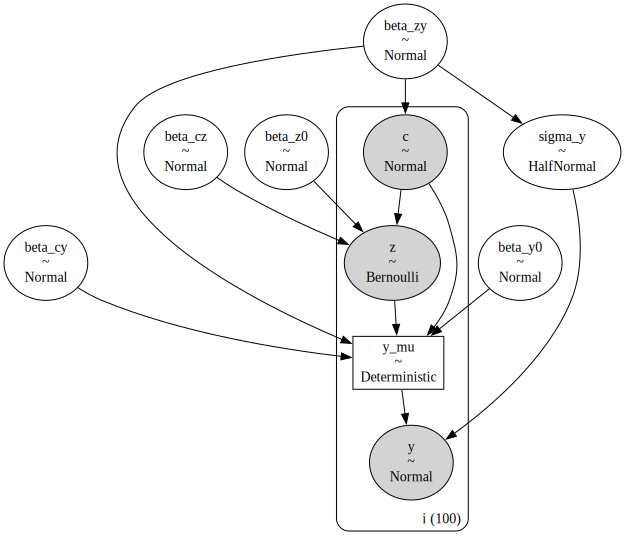

In [20]:
model_inference = observe(model_generative, {"c": observed['c'], "y": observed['y'], "z": observed['z']})
model_inference.set_dim("i", N, coord_values=np.arange(N))

pm.model_to_graphviz(model_inference)

<div class="alert alert-block alert-info">
<b>Note:</b> Again, we've got a new and different model back after we've used the observe function.</div>

Now we can press the Inference Button and sample from our posterior.

In [21]:
with model_inference:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_y0, beta_cy, beta_cz, beta_z0, beta_zy, sigma_y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


We can inspect our posterior distributions easily using `arviz`. By plotting the known parameter values we used to generate the simulated data, we can confirm that the inference step has done a good job of estimating these values.

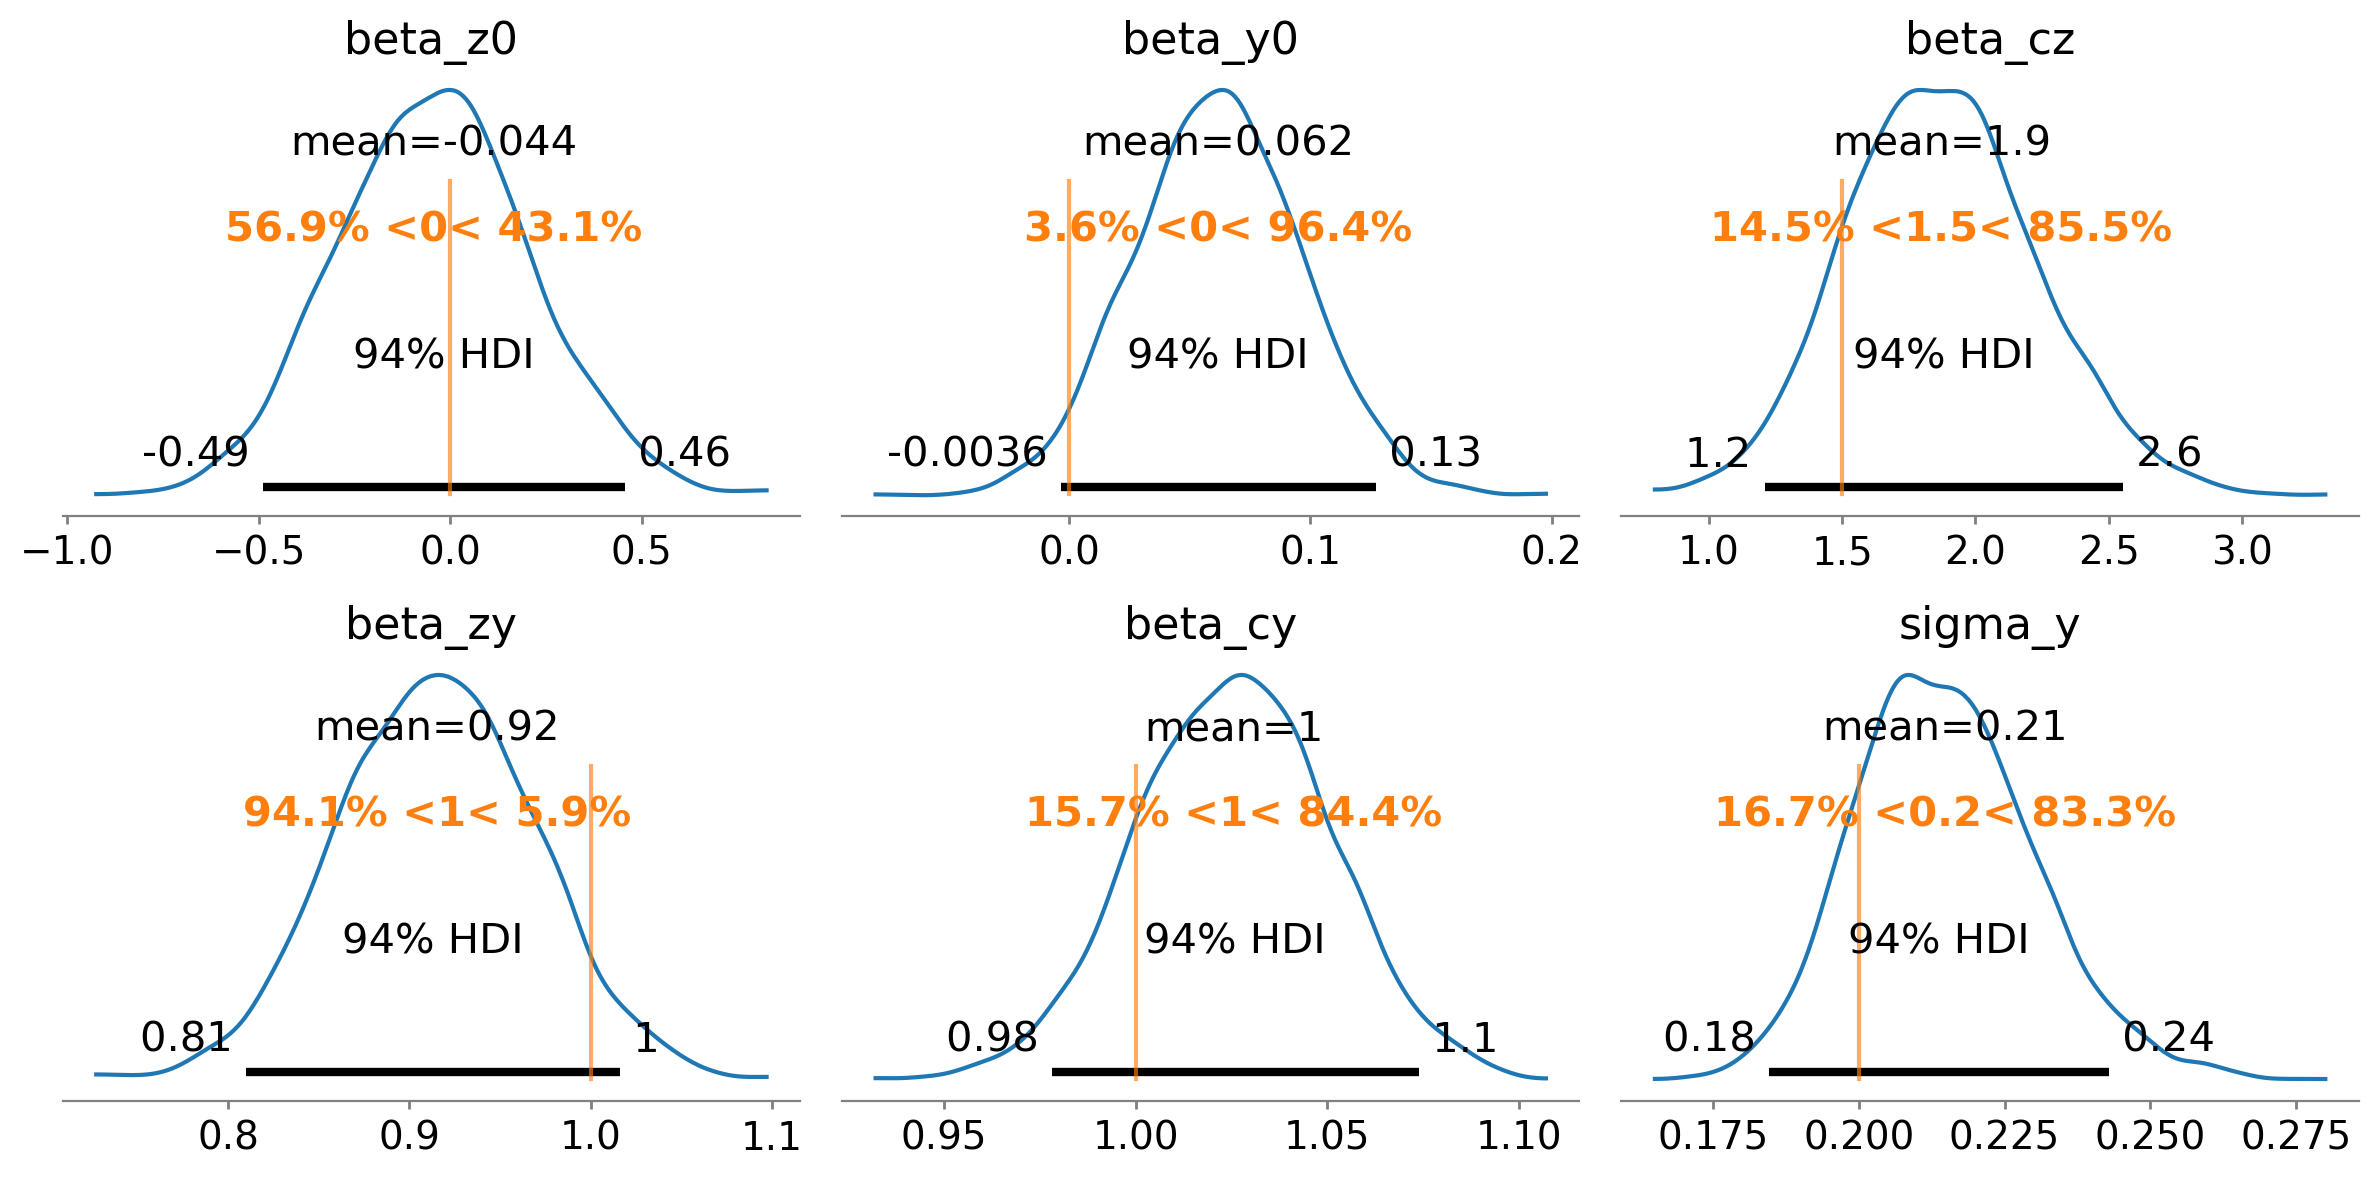

In [22]:
az.plot_posterior(idata, 
                  var_names=list(true_values.keys()), 
                  ref_val=list(true_values.values()), 
                  figsize=(12,6))
plt.tight_layout();

### Counterfactuals

# TODO: Gut feeling is that we want a separate blog post on the difference between intervention and counterfactuals and how PyMC can do those. So just give a light-touch explanation here

# TODO: Explain the ATE here and what exactly we are doing

In [23]:
# P(Y | c, do(z=0))
with do(model_inference, {"z": np.zeros(N, dtype='int32')}, prune_vars=True) as model_control:
    idata_z0 = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_mu"])

# P(Y | c, do(z=1))
with do(model_inference, {"z": np.ones(N, dtype='int32')}, prune_vars=True) as model_treat:
    idata_z1 = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y_mu"])

Sampling: [c]


Sampling: [c]


In [24]:
# calculate estimated ITE
ATE_est = idata_z1.predictions - idata_z0.predictions

# ERROR: `c` and `y` reverted back to RV's, not observed?

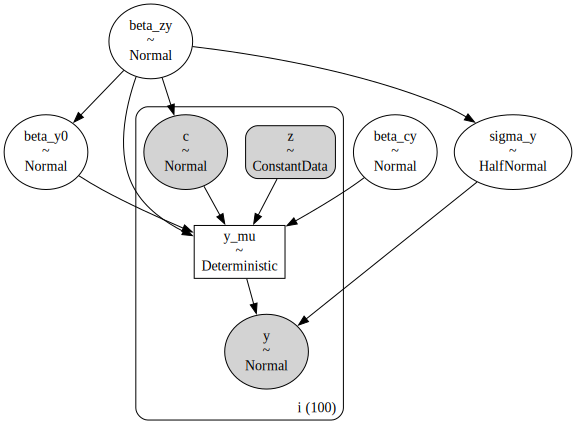

In [25]:
pm.model_to_graphviz(model_control)

In [26]:
def plot_causal_estimates(models, ATE_est, model_names):
    """Utility plot function to generate figure for estimated outcomes and causal effects."""
    fig, ax = plt.subplots(1, 2)
    # left plot of estimated outcomes
    ret = az.plot_forest(
        [models[0].predictions, models[1].predictions],
        combined=True,
        ax=ax[0],
        model_names=model_names,
    )
    # remove alternate row shading
    for p in ret[0].patches:
        p.set_color("white")
    # right plot of estimated ITE
    az.plot_forest(ATE_est, combined=True, ax=ax[1])
    # formatting
    ax[0].set(
        title="Estimated outcomes under intervention",
        ylabel="unit, $i$ (ordered)",
        yticklabels=[],
    )
    ax[1].axvline(true_ATE, color="red", label="true ATE")
    ax[1].legend()
    ax[1].set(
        title=f"Estimated ITE's\nPercentage error = "
        + print_percent_error(ATE_est, true_ATE),
        xlim=(1 - 3, 1 + 3),
        yticklabels=[],
    )
    plt.tight_layout()

In [27]:
def print_percent_error(ATE_est, true_ATE):
    """Utility function to calculate and print the percent error."""
    percent_error = np.abs(ATE_est["y_mu"] - true_ATE) / true_ATE * 100
    hdi = az.hdi(percent_error).sel(i=0)["y_mu"].values
    return f"{percent_error.mean().data:.1f}% ({hdi[0]:.1f} - {hdi[1]:.1f})"

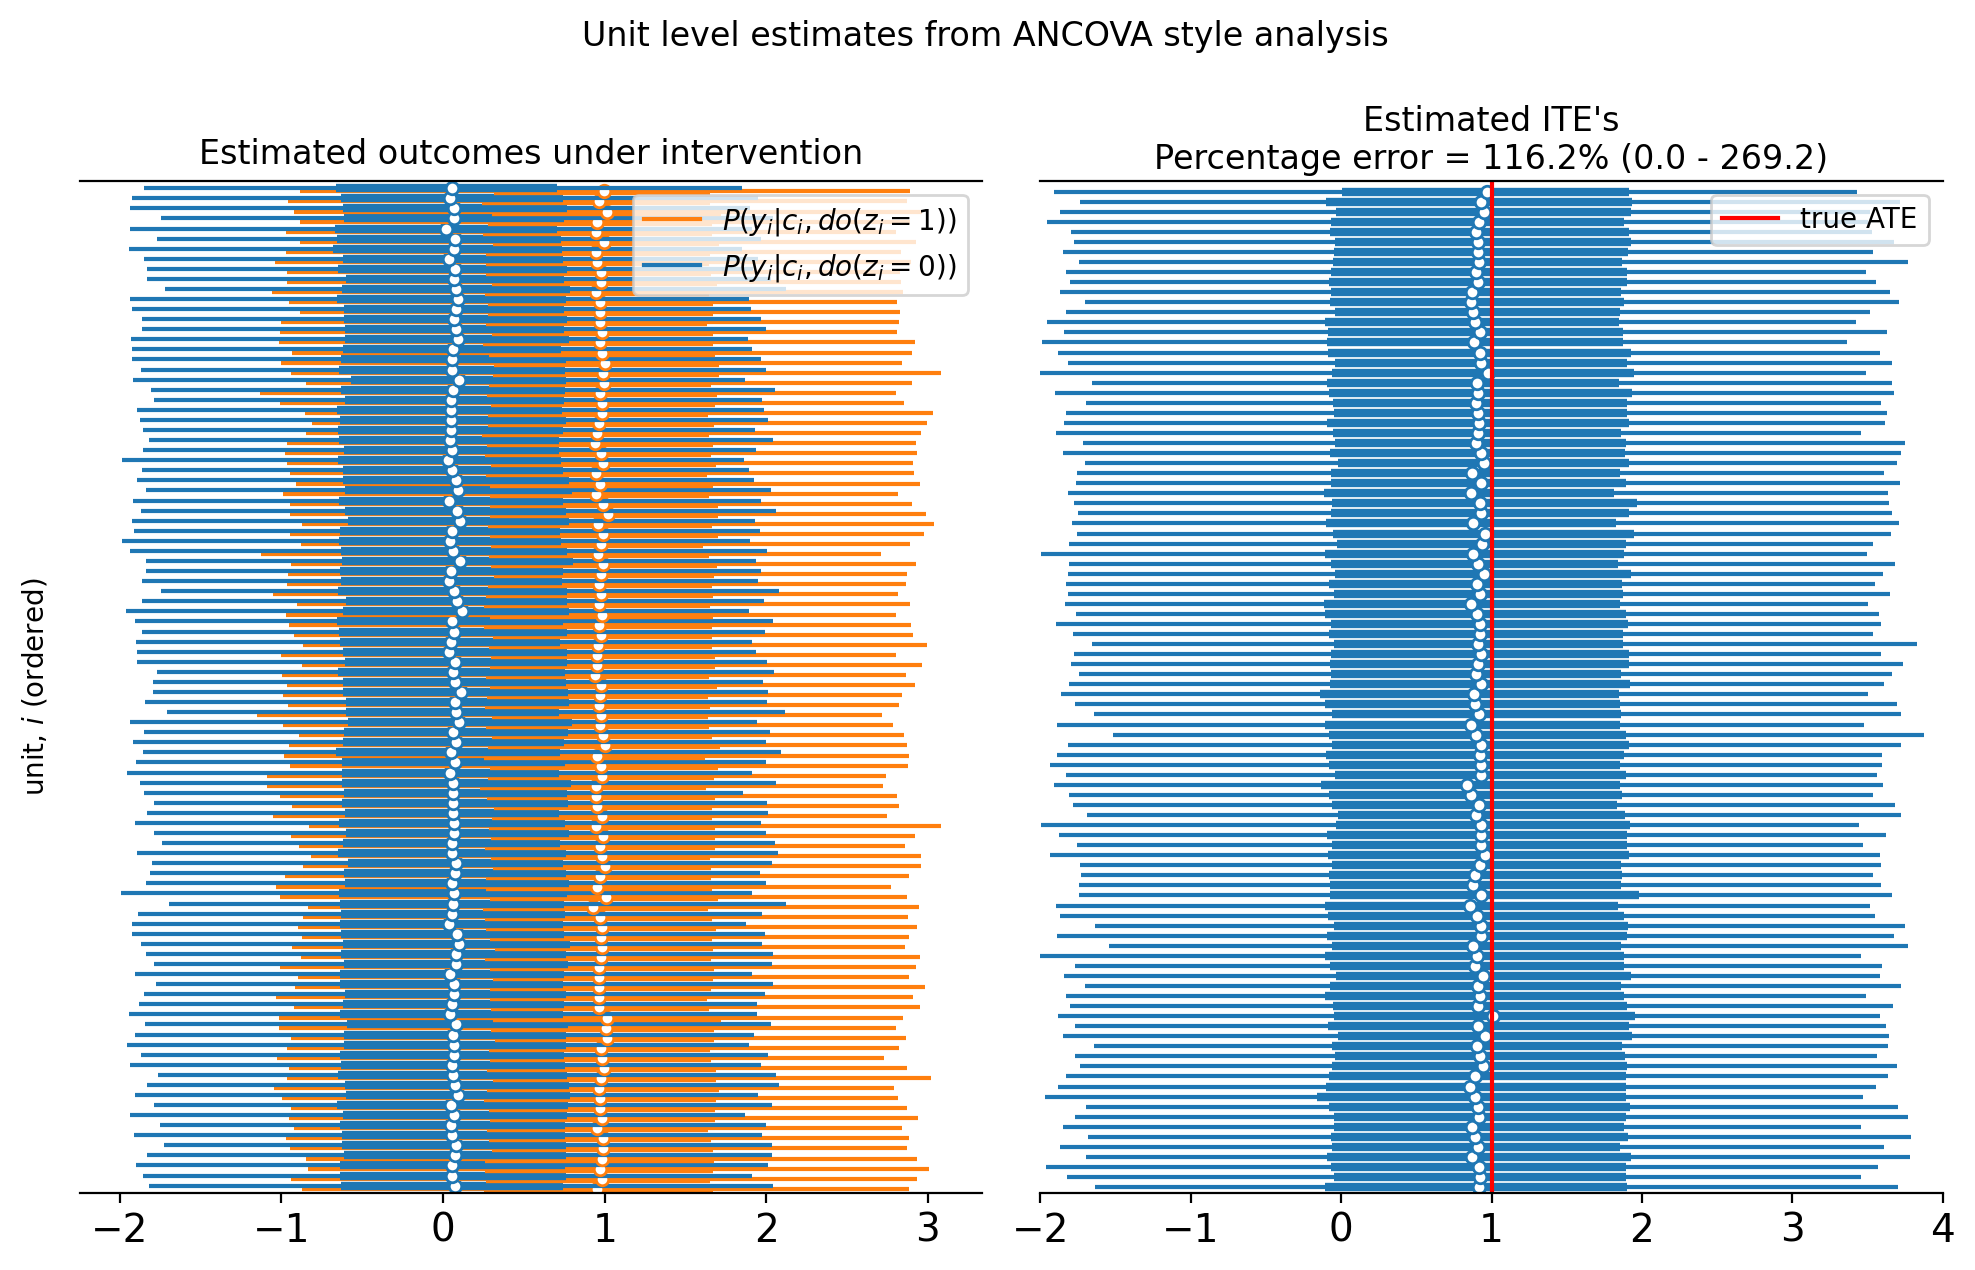

In [28]:
plot_causal_estimates(
    [idata_z0, idata_z1],
    ATE_est,
    model_names=[r"$P(y_i|c_i,do(z_i=0))$", r"$P(y_i|c_i,do(z_i=1))$"],
)
plt.suptitle("Unit level estimates from ANCOVA style analysis", y=1.05);

# ERROR: Because of the above errors, this plot is wrong. We should see different estimates for each unit in the left plot, because they have unique values of the confounding variable

# TODO: The right had plot which shows ITE's (treatment effects for each person) may not be valid. 

Pearl states that the we calculate the causal effect with $P(y|c,do(z=1)) - P(y|c,do(z=0))$ which we do for each individual. 

As far as I understand the ITE has to be identical for each person because we are only modelling an ATE (by the $z \rightarrow y$ coefficient).

But Ricardao raises a good point about doing sample-wise subtraction to calculate the effects, or if we should shuffle the posterior samples for $P(y|c,do(z=1))$ vs $P(y|c,do(z=0))$. We aren't sure what is the correct method is, but it would have an effect, because the latter approach would have higher variance (because of the variance sum rule).

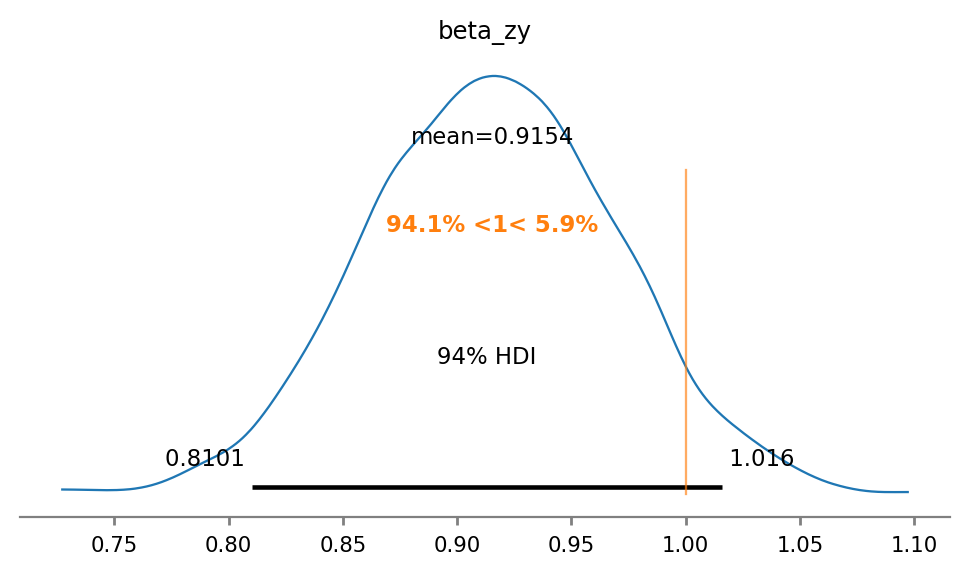

In [29]:
az.plot_posterior(idata, var_names="beta_zy", ref_val=true_ATE, round_to=4, figsize=(6,3));

# TODO - finish the blogpost